# <center> <b> <font color='#0E6655'> 1. ELECTRICAL PRODUCTION </center> </b> </font>

## Table of Contents

1. [Problem Statement](#1)
2. [Modules](#2)
3. [Helper Functions](#3)
4. [Data Loading and pre-processing](#4)
5. [Model selection](#5)
6. [Making predictions](#6)
7. [Annex](#annex)


<a name="1"></a>
## <font color='green'> <b> 1. Problem Statement </font> </b>

We're gonna predict the electrical production. It is a time series problem.

<a name="2"></a>
## <font color='green'> <b> 2. Modules </font> </b>

In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [5]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)
import pandas as pd

<a name="3"></a>
## <font color='green'> <b> 3. Helper Functions </font> </b>

In [70]:
# plot time series
def plot_series(time, series, xlabel, ylabel, format="-", start=0, end=None, color='blue'):
    plt.plot(time[start:end], series[start:end], format, color=color)

    # imprimit sólo algunos valores de x (que no quede tan sobrecargado)
    ticks_interval = 50
    plt.xticks(data.index[::ticks_interval], data.index[::ticks_interval])

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    
    
    
# train/test split
def train_val_split(time, series, split_size):
    """
    Split the time series data into training and validation sets.
    We do not shuffle the data because is a time series problem.

    Parameters:
    - time (list-like): List or array containing the time index of the time series.
    - series (list-like): List or array containing the values of the time series.
    - split_size (float): The proportion of data to be allocated for training.
                          Value should be between 0 and 1.

    Returns:
    - time_train (list-like): Time index of the training set.
    - series_train (list-like): Values of the training set.
    - time_valid (list-like): Time index of the validation set.
    - series_valid (list-like): Values of the validation set.

    Example:
        If time = [1, 2, 3, 4, 5] and series = [10, 20, 30, 40, 50],
            and split_size = 0.8, then the function returns:
                time_train = [1, 2, 3]
                series_train = [10, 20, 30]
                time_valid = [4, 5]
                series_valid = [40, 50]
    """
    
    # índice de la divisón
    training_size = int(len(time)*split_size)

    time_train = time[:training_size]
    series_train = series[:training_size]
    time_valid = time[training_size:]
    series_valid = series[training_size:]

    return time_train, series_train, time_valid, series_valid


# windowing the dataset
def windowed_dataset(series, 
                     window_size, 
                     batch_size, 
                     shuffle_buffer=200,
                     shuffle=True):
     
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True) # drop_remainder -> all of the same size
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1])) #w[:-1] all but the last; w[-1]: the last
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# forecast
def model_forecast(model, series, window_size):
    """
    The code to implement this is provided in the model_forecast below. Notice that the code is very similar to the one in the windowed_dataset function with the differences that:

    The dataset is windowed using window_size rather than window_size + 1
    No shuffle should be used
    No need to split the data into features and labels
    A model is used to predict batches of the dataset
    """
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

<a name="4"></a>
## <font color='green'> <b> 4. Loading data an pre-processing </font> </b>

### Loading data

In [7]:
!cd data && ls

Electric_Production.csv


In [8]:
data = pd.read_csv('data/Electric_Production.csv')
data.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


### Exploration

In [9]:
data.shape

(397, 2)

In [10]:
data.columns

Index(['DATE', 'IPG2211A2N'], dtype='object')

In [11]:
times = data['DATE']
consumption = data['IPG2211A2N']

In [19]:
@dataclass
class G:
    #TEMPERATURES_CSV = './data/daily-min-temperatures.csv'
    #times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = times.values
    SERIES = consumption.values
    SPLIT_TIME = 250 # cambiar dsp!!!
    WINDOW_SIZE = 7
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 200
    SPLIT_SIZE=0.8



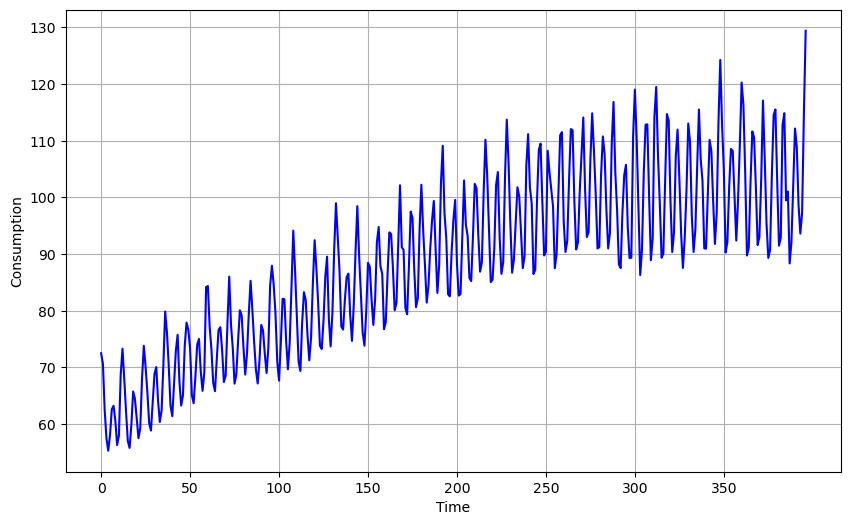

In [71]:
# plot time series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES, 'Time', 'Consumption')
plt.show()

### Train/test split

In [27]:
# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES,G.SPLIT_SIZE)

In [30]:
time_train.shape, series_train.shape, time_valid.shape, series_valid.shape

((317,), (317,), (80,), (80,))

### Windowing the dataset

We do this to convert a time series problem into a supervised learning problem.

In [42]:
# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, 
                             batch_size=G.BATCH_SIZE) #shuffle_buffer=G.SHUFFLE_BUFFER_SIZE

In [43]:
# Create windowed datasets for training and validation
val_set = windowed_dataset(series_valid, window_size=G.WINDOW_SIZE, 
                           batch_size=G.BATCH_SIZE,shuffle=False)


<a name="5"></a>
## <font color='green'> <b> 5. Model Selection </font> </b>


In [35]:
# to save results
results = []

### Baseline

In [36]:
# naive forecast
naive_forecast = series_valid[:-1]

# Calcula el MAE entre la serie de validación y el naive forecast
mae = tf.keras.losses.mean_absolute_error(series_valid[1:], naive_forecast)

# show
mae.numpy()

8.27027594936709

In [37]:
results.append({'name':'Naive Forecast','mae':mae.numpy()})

### Model 1

- Lambda
- Bidirectional x2
- Output Dense
- Rescaling

In [38]:
def build_model_one():
    
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),input_shape=[None]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x*100.0) #rescaling
    ]) 
    
    model.compile(loss='mae',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=["mae"]) 

    return model

In [39]:
model_one = build_model_one()
model_one.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 bidirectional (Bidirection  (None, None, 256)         133120    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 297601 (1.14 MB)
Trainable params: 297601 

In [47]:
# Fit the model
history_one = model_one.fit(
            train_set,
            epochs=20,
            verbose=0,
            batch_size=64,
            validation_data=val_set)

In [48]:
scores_one = model_one.evaluate(val_set)

3/3 [==============================] - 0s 9ms/step - loss: 3.7589 - mae: 3.7589


In [49]:
results.append({'name':'Model 1','mae':scores_one[0]})

### Model 2

- Conv1D layer
- LSTM x2
- Dense x2
- Output Dense

In [51]:
def build_model_two():

    model = tf.keras.models.Sequential([ 
            tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                                  input_shape=[None, 1]),
              tf.keras.layers.LSTM(64, return_sequences=True),
              tf.keras.layers.LSTM(64),
              tf.keras.layers.Dense(30, activation="relu"),
              tf.keras.layers.Dense(10, activation="relu"),
              tf.keras.layers.Dense(1),
    ]) 
    
    model.compile(loss='mae',
                  optimizer='adam',
                  metrics=["mae"]) 
    
    return model


In [52]:
model_two = build_model_two()
model_two.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 64)          256       
                                                                 
 lstm_2 (LSTM)               (None, None, 64)          33024     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 30)                1950      
                                                                 
 dense_2 (Dense)             (None, 10)                310       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 68575 (267.87 KB)
Trainable params: 6857

In [53]:
history_two = model_two.fit(
            train_set,
            epochs=20,
            verbose=0,
            batch_size=64,
            validation_data=val_set)

In [54]:
scores_two = model_two.evaluate(val_set)

3/3 [==============================] - 0s 7ms/step - loss: 16.0378 - mae: 16.0378


In [55]:
results.append({'name':'Model 2','mae':scores_two[0]})

### Comparing results

In [56]:
results = pd.DataFrame(results)
results

,name,mae
0,Naive Forecast,8.270276
1,Model 1,3.758896
2,Model 2,16.037830


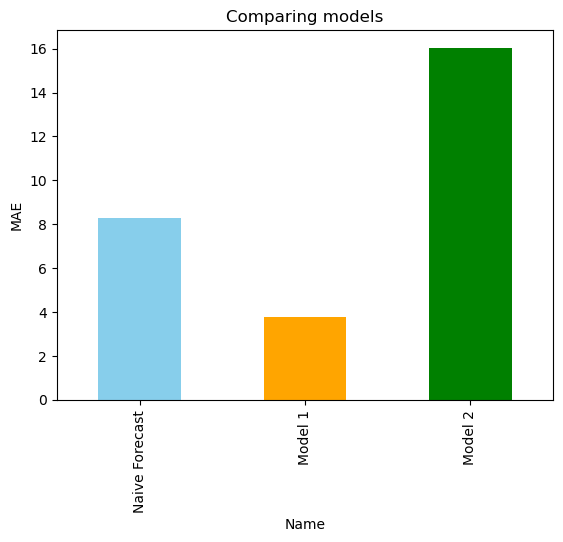

In [58]:
# Define colors for each bar
colors = ['skyblue', 'orange', 'green']

# Plotting the bar plot
results.plot(x='name', y='mae', kind='bar', color=colors, legend=False)

# Adding labels and title
plt.xlabel('Name')
plt.ylabel('MAE')
plt.title('Comparing models')

# Display the plot
plt.show()

We can see that our best model is "Model 1".

<a name="6"></a>
## <font color='green'> <b> 6. Making predictions </font> </b>

We're gonna make predictions with the validation data and our best model.

In [64]:
forecast = model_one.predict(val_set)

3/3 [==============================] - 1s 10ms/step


In [66]:
forecast[:3] # first three

array([[112.98294],
       [108.63103],
       [ 96.72316]], dtype=float32)

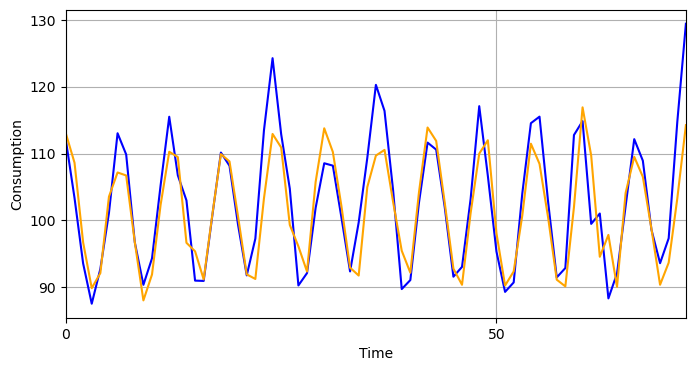

In [75]:
# Plot the forecast
plt.figure(figsize=(8, 4))
plot_series(time_valid[G.WINDOW_SIZE:], series_valid[G.WINDOW_SIZE:], xlabel='Time', ylabel='Consumption',
                       color='blue')
plot_series(time_valid[G.WINDOW_SIZE:], forecast, xlabel='Time', ylabel='Consumption',
               color='orange')

# 
plt.xlim(time_valid[G.WINDOW_SIZE], time_valid[-1])

plt.show()

<a name="annex"></a>
## <font color='green'> <b> ANNEX</font> </b>

<b> About windowing the dataset: </b>


It's common practice to apply the windowing transformation separately to both the training and validation sets when working with time series data. However, the specifics of how you handle shuffling differ between the training and validation sets.

<font color='#0E6655'> For the training set </font>

- Shuffling the data is typically done to prevent the model from memorizing the order of the sequences and to introduce randomness, which can help in better generalization during training. 
- You should shuffle the training set.


<font color='#0E6655'> For the validation set </font>

- Shuffling is generally not necessary or desirable because you want to evaluate the model's performance on data that reflects the real temporal structure of the time series.
- You should not shuffle the validation set.


In summary, you should apply windowing to both the training and validation sets, but you should shuffle the training set and not shuffle the validation set. This ensures that your model learns from shuffled sequences during training while evaluating its performance on the original temporal structure during validation.

In [84]:
# example of what the windowed dataset function does

aux_data = [1,2,3,4,5,6,7,8]

aux_windowed_data = windowed_dataset(aux_data, 
                     window_size=3, 
                     batch_size=32)


In [85]:
aux_windowed_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [99]:
for x,y in aux_windowed_data:
    print(f" Data\n {x.numpy()}, \n\nLabels\n {y.numpy()}")

 Data
 [[5 6 7]
 [3 4 5]
 [4 5 6]
 [1 2 3]
 [2 3 4]], 

Labels
 [8 6 7 4 5]


For [5 6 7], the label is 8, for [3 4 5], is 6 .....